<a href="https://colab.research.google.com/github/mayank-liv/Traffic-Image-Segmentation/blob/master/Traffic_Image_Segmentation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Object Segmentation

## 1. Loading the data to runtime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!unzip '/content/drive/My Drive/lyft-udacity-challenge.zip'

Archive:  /content/drive/My Drive/lyft-udacity-challenge.zip
  inflating: dataA.tar.gz            
  inflating: dataE.tar.gz            
  inflating: dataC.tar.gz            
  inflating: dataB.tar.gz            
  inflating: dataD.tar.gz            


In [9]:
!tar -xvf /content/dataD.tar.gz

dataD/
dataD/CameraRGB/
dataD/CameraRGB/03_00_247.png
dataD/CameraRGB/02_00_217.png
dataD/CameraRGB/F69-56.png
dataD/CameraRGB/04_00_066.png
dataD/CameraRGB/F63-86.png
dataD/CameraRGB/03_00_136.png
dataD/CameraRGB/F3-97.png
dataD/CameraRGB/02_01_036.png
dataD/CameraRGB/F66-97.png
dataD/CameraRGB/03_01_216.png
dataD/CameraRGB/07_00_206.png
dataD/CameraRGB/07_00_107.png
dataD/CameraRGB/F8-66.png
dataD/CameraRGB/04_00_207.png
dataD/CameraRGB/02_02_116.png
dataD/CameraRGB/F62-46.png
dataD/CameraRGB/03_01_196.png
dataD/CameraRGB/09_00_217.png
dataD/CameraRGB/03_00_047.png
dataD/CameraRGB/F64-76.png
dataD/CameraRGB/F2-16.png
dataD/CameraRGB/F68-7.png
dataD/CameraRGB/F9-56.png
dataD/CameraRGB/F70-76.png
dataD/CameraRGB/08_00_117.png
dataD/CameraRGB/F61-87.png
dataD/CameraRGB/05_00_037.png
dataD/CameraRGB/08_00_226.png
dataD/CameraRGB/09_00_167.png
dataD/CameraRGB/03_01_197.png
dataD/CameraRGB/05_00_007.png
dataD/CameraRGB/02_01_226.png
dataD/CameraRGB/09_00_166.png
dataD/CameraRGB/07_00_197.p

## 2. Import Libraries needed for the model -

In [0]:
import numpy as np  # For using linear algebra 
import pandas as pd # For data processing and using Pandas dataframes

from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

import os           # For interacting with the operating system

from tqdm import tqdm  #Helps show a progress bar when we need, like during model formation

import imageio         #provides interface to read and write and manipulate image data

import matplotlib.pyplot as plt    #to help plot graphs and figures
%matplotlib inline


In [6]:
# The following libraries are for the actual model

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.layers.core import Lambda, RepeatVector, Reshape


Using TensorFlow backend.


## 3. Create a list of images

In [0]:
path_img = '../content/dataD/CameraRGB/'
path_seg = '../content/dataD/CameraSeg/'
list_img = os.listdir(path_img)   #This will be a list containing all the original images where object segmentation needs to happen
list_seg = os.listdir(path_seg)   #This will be a list of all the images post segmentation, that has been provided in the dataset
list_img = [path_img+i for i in list_img]
list_seg = [path_seg+i for i in list_seg]

## 4. Visualisation of Images

Text(0.5, 1.0, 'Image after Segmentation')

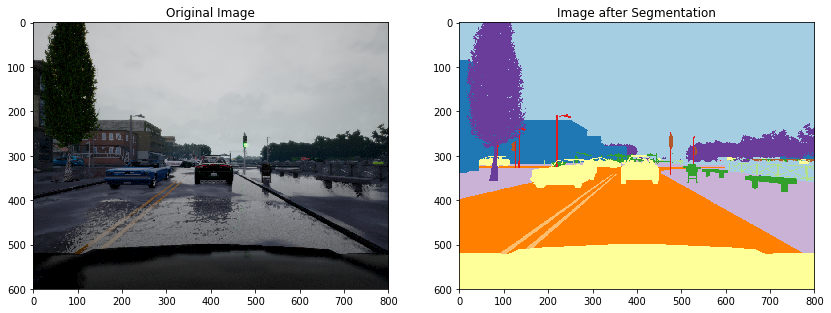

In [18]:
image = imageio.imread(list_img[2])
seg = imageio.imread(list_seg[2])

seg = np.array([max(seg[i, j]) for i in range(seg.shape[0]) for j in range(seg.shape[1])]).reshape(image.shape[0], image.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(image)
arr[0].set_title('Original Image')
arr[1].imshow(seg, cmap='Paired')
arr[1].set_title('Image after Segmentation')

Text(0.5, 1.0, 'Image after Segmentation')

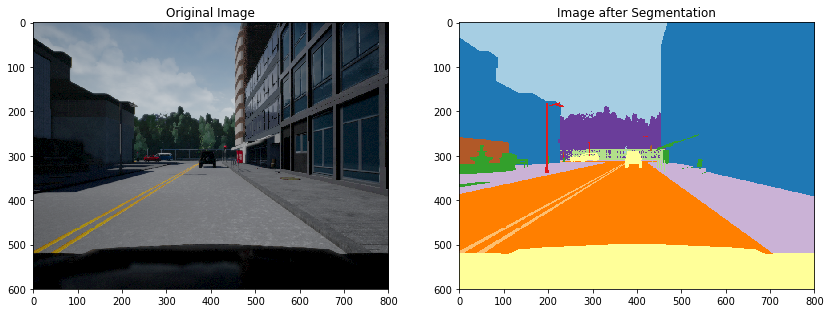

In [19]:
image = imageio.imread(list_img[8])
seg = imageio.imread(list_seg[8])

seg = np.array([max(seg[i, j]) for i in range(seg.shape[0]) for j in range(seg.shape[1])]).reshape(image.shape[0], image.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(image)
arr[0].set_title('Original Image')
arr[1].imshow(seg, cmap='Paired')
arr[1].set_title('Image after Segmentation')

### For the purpose of this project, due to computational and memory limits, we will focus just on the segemtation of the road, rather than all the objects in the image. The tag of a road is 7, which one can find at [Cameras semantic segmentation website](https://carla.readthedocs.io/en/latest/cameras_and_sensors/#camera-semantic-segmentation)

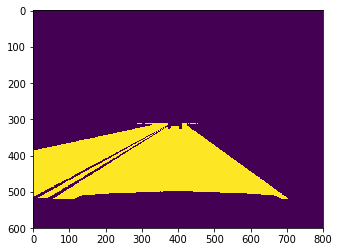

In [21]:
# visualise the images with only the road segmented out

road = np.zeros((600, 800))
road[np.where(seg==7)[0], np.where(seg==7)[1]]=1
plt.imshow(road)

### Altering the semantic segmented images so that it only shows the road segmented out of the image

In [22]:
height = 600
width= 800


imgs = np.zeros((len(list_img), height, width, 3), dtype=np.int16)  #initialise as a matrix of 0s
segs = np.zeros((len(list_seg), height, width, 1), dtype=np.int8)   #initialise as a matrix of 0s

for i in tqdm(range(len(list_img))):
    image = imageio.imread(list_img[i])
    
    seg_img = imageio.imread(list_seg[i])
    seg_road = np.zeros((600, 800, 1), dtype=np.int8)
    seg_road[np.where(seg_img==7)[0], np.where(seg_img==7)[1]]=1
    
    imgs[i] = image
    segs[i] = seg_road

100%|██████████| 1000/1000 [00:31<00:00, 32.21it/s]


## 5. Build the Model

In [0]:
np.random.seed(123)
shuffle = np.array([i for i in range(len(segs))])
np.random.shuffle(shuffle)
train_ids = shuffle[:int(len(segs)*0.8)]        # We use 80% images for training
val_ids = shuffle[int(len(segs)*0.8):int(len(segs)*0.8+100)]   # 10% images for cross-validation
test_ids = shuffle[int(len(segs)*0.8+100):]     # 10% images for testing model



train_images, train_segs = imgs[train_ids], segs[train_ids]
val_images, val_segs = imgs[val_ids], segs[val_ids]
test_images, test_segs = imgs[test_ids], segs[test_ids]

In [35]:
# Build U-Net model


input_img = Input((height, width, 3), name='img')

conv1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same') (conv1)
pool1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(16, (3, 3), activation='relu', padding='same') (pool1)
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same') (conv2)
pool2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same') (pool2)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same') (conv3)
pool3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same') (pool3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same') (conv4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv4)
u5 = concatenate([u5, conv3])
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
conv6 = Conv2D(32, (3, 3), activation='relu', padding='same') (conv6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv6)
u7 = concatenate([u7, conv2])
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same') (conv7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv7)
u8 = concatenate([u8, conv1])
conv8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
conv8 = Conv2D(8, (3, 3), activation='relu', padding='same') (conv8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv8)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 600, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 600, 800, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 600, 800, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 300, 400, 8)  0           conv2d_2[0][0]            

In [37]:
# Inorder to terminate training if the accuracy doesn't improve with training

callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-sdc-seg-v2.h5', verbose=1, save_best_only=True)
]

results = model.fit(train_images, train_segs, batch_size=16, epochs=100, callbacks=callbacks,
                    validation_data=(val_images, val_segs))


Train on 800 samples, validate on 100 samples
Epoch 1/100
800/800 [==============================] - 49s 62ms/step - loss: 0.6657 - val_loss: 0.4281

Epoch 00001: val_loss improved from inf to 0.42808, saving model to model-sdc-seg-v2.h5
Epoch 2/100
800/800 [==============================] - 34s 43ms/step - loss: 0.3946 - val_loss: 0.3925

Epoch 00002: val_loss improved from 0.42808 to 0.39250, saving model to model-sdc-seg-v2.h5
Epoch 3/100
800/800 [==============================] - 34s 43ms/step - loss: 0.3709 - val_loss: 0.3713

Epoch 00003: val_loss improved from 0.39250 to 0.37131, saving model to model-sdc-seg-v2.h5
Epoch 4/100
800/800 [==============================] - 35s 44ms/step - loss: 0.3752 - val_loss: 0.3916

Epoch 00004: val_loss did not improve from 0.37131
Epoch 5/100
800/800 [==============================] - 35s 44ms/step - loss: 0.3455 - val_loss: 0.3050

Epoch 00005: val_loss improved from 0.37131 to 0.30500, saving model to model-sdc-seg-v2.h5
Epoch 6/100
800/80

In [0]:
model.save('model_road_seg.h5')

## 6. Visualising the results -

Text(0.5, 1.0, 'Real segmented part of road')

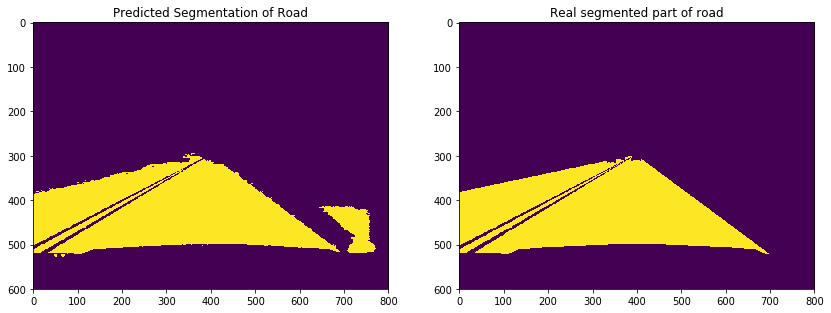

In [45]:
# We check the 2nd image's segmentation results


preds = model.predict(np.expand_dims(test_images[1], 0))
preds = preds.flatten()
preds = np.array([1 if i >= 0.5 else 0 for i in preds])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,10))
ax[0].imshow(preds.reshape(600, 800))
ax[0].set_title('Predicted Segmentation of Road')
ax[1].imshow(test_segs[1].reshape(600, 800))
ax[1].set_title('Real segmented part of road')